In [180]:
%matplotlib inline

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10)
import numpy as np
import seaborn as sns

# EDA
## Load Data

In [182]:
Posts = pd.read_csv('/Users/esmondchu/Dropbox/160-Stackoverflow-Data/300000_rows_[504_MB]/Posts.csv')

## Check NA of Posts

Text(0.5,1,'Posts NA')

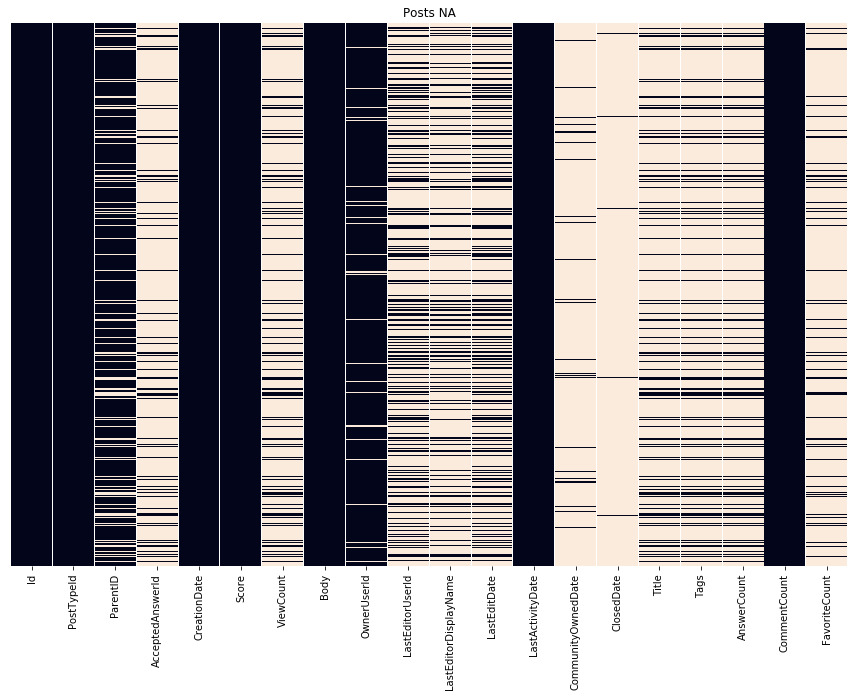

In [183]:
sns.heatmap(Posts.isnull(), yticklabels=False, cbar=False)
plt.title('Posts NA')

In [184]:
Posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 20 columns):
Id                       300000 non-null int64
PostTypeId               300000 non-null int64
ParentID                 236239 non-null float64
AcceptedAnswerId         48185 non-null float64
CreationDate             300000 non-null object
Score                    300000 non-null int64
ViewCount                63761 non-null float64
Body                     300000 non-null object
OwnerUserId              285662 non-null float64
LastEditorUserId         103583 non-null float64
LastEditorDisplayName    67816 non-null object
LastEditDate             104904 non-null object
LastActivityDate         300000 non-null object
CommunityOwnedDate       14309 non-null object
ClosedDate               5037 non-null object
Title                    63761 non-null object
Tags                     63762 non-null object
AnswerCount              63761 non-null float64
CommentCount             300000

# Timely Collaboration and Values
## Answers Posts

In [185]:
import datetime
import calendar

#date to timestamp
def date_ts(s):
    """ 
    param s: str - date
    returns: int - timestamp
    """
    date = datetime.datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")
    st = calendar.timegm(date.utctimetuple())
    return(st)

In [186]:
df_answers = Posts[Posts.PostTypeId == 2]

In [187]:
df_answers = df_answers.reset_index(drop=True)

In [188]:
df_answers.CreationDate = df_answers.CreationDate.str[:-4]

In [189]:
unix_ans = [date_ts(i) for i in df_answers.CreationDate]

In [190]:
df_answers_time = pd.DataFrame({'ParentID':df_answers.ParentID, 'Cr_time':unix_ans})

In [191]:
df_list = df_answers_time.groupby(df_answers_time.ParentID)

In [192]:
uni_par_id = list(df_answers_time.ParentID.unique())

In [193]:
ans_date = [list(df_list.get_group(i).Cr_time) for i in uni_par_id]

In [194]:
yes = 0
no = 0
for i in ans_date:
    if len(i) == 1:
        yes += 1
    else:
        no += 1
print(yes, no)

#there are 2917 posts with only 1 answer, 15773 posts with more than 1 answers.

11868 50552


In [195]:
#set 1-answer post sd to 0
for i in ans_date:
    if len(i) == 1:
        i.append(i[0])
    else:
        i == i

In [196]:
import statistics
ans_time_sd = [statistics.stdev(i) for i in ans_date]

In [197]:
post_Id = sorted(list(df_answers.ParentID.unique()))

In [198]:
post_ans_sd = pd.DataFrame({'post_Id':post_Id, 'time_sd':ans_time_sd})

In [199]:
post_ans_sd.head()

,post_Id,time_sd
0,4.0,3.638888e+06
1,6.0,2.139598e+06
2,9.0,2.005625e+06
3,11.0,2.019398e+06
4,13.0,9.701637e+05


## Parents Posts

In [200]:
Parents_post = Posts[Posts.PostTypeId == 1]

In [201]:
Parents_post = Parents_post.reset_index(drop=True)

In [202]:
Parents_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63761 entries, 0 to 63760
Data columns (total 20 columns):
Id                       63761 non-null int64
PostTypeId               63761 non-null int64
ParentID                 0 non-null float64
AcceptedAnswerId         48185 non-null float64
CreationDate             63761 non-null object
Score                    63761 non-null int64
ViewCount                63761 non-null float64
Body                     63761 non-null object
OwnerUserId              57492 non-null float64
LastEditorUserId         43692 non-null float64
LastEditorDisplayName    31554 non-null object
LastEditDate             44445 non-null object
LastActivityDate         63761 non-null object
CommunityOwnedDate       1884 non-null object
ClosedDate               5037 non-null object
Title                    63761 non-null object
Tags                     63761 non-null object
AnswerCount              63761 non-null float64
CommentCount             63761 non-null int64
Fa

In [203]:
df_parents = pd.DataFrame({'post_Id':Parents_post.Id, 'Views_count':Parents_post.ViewCount,\
                           'Score':Parents_post.Score, 'Comment_count':Parents_post.CommentCount})

In [204]:
df_comb = df_parents.join(post_ans_sd.set_index('post_Id'), on='post_Id')

In [205]:
df_comb.head()

,Comment_count,Score,Views_count,post_Id,time_sd
0,1,543,34799.0,4,3.638888e+06
1,0,241,15696.0,6,2.139598e+06
2,16,1716,439828.0,9,2.005625e+06
3,3,1286,130055.0,11,2.019398e+06
4,6,519,149911.0,13,9.701637e+05


## Plots

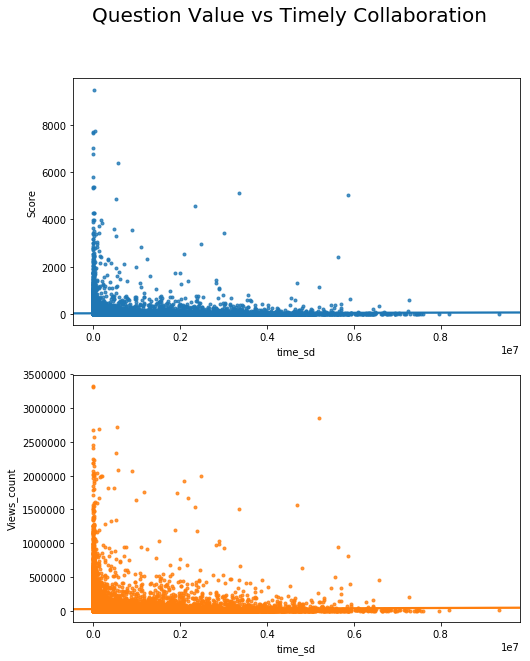

In [206]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, df_comb.Score, marker=".", ax=ax1)
sns.regplot(df_comb.time_sd, df_comb.Views_count, marker=".", ax=ax2)

## Data transformation

In [207]:
df_comb.head()

,Comment_count,Score,Views_count,post_Id,time_sd
0,1,543,34799.0,4,3.638888e+06
1,0,241,15696.0,6,2.139598e+06
2,16,1716,439828.0,9,2.005625e+06
3,3,1286,130055.0,11,2.019398e+06
4,6,519,149911.0,13,9.701637e+05


In [208]:
df_comb.Views_count.describe()

count    6.376100e+04
mean     2.319304e+04
std      9.509128e+04
min      3.900000e+01
25%      1.128000e+03
50%      3.280000e+03
75%      1.178500e+04
max      3.328490e+06
Name: Views_count, dtype: float64

In [209]:
df_comb.Score.describe()

count    63761.000000
mean        28.935509
std        165.140779
min         -7.000000
25%          2.000000
50%          4.000000
75%         13.000000
max       9484.000000
Name: Score, dtype: float64

In [210]:
import math
def loga(x):
    val = x+9
    out = 1/math.log10(val)
    return(out)

In [211]:
View_log = df_comb.Views_count.apply(loga)

In [212]:
Scores_log = df_comb.Score.apply(loga)

In [213]:
yes = 0
no = 0
for i in df_comb.Score:
    if i < 0:
        yes += 1
    else:
        no += 1
print(yes, no)

420 63341


## Plot of Transformed Data

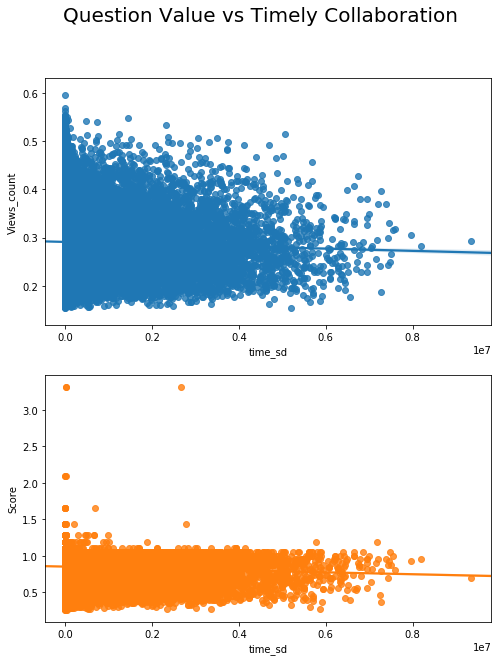

In [214]:
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,10))
plt.suptitle("Question Value vs Timely Collaboration", size=20)
sns.regplot(df_comb.time_sd, View_log, ax=ax1)
sns.regplot(df_comb.time_sd, Scores_log, ax=ax2)

# Probability of a question being answered as a function of time in minutes
eg. $P(\text{question is answered}|t=0,...,n , n=1,...,1440)$ for 

## Parents Post Data Wrangling

In [215]:
#Parents_post
df_answers

,Id,PostTypeId,ParentID,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,CommunityOwnedDate,ClosedDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,7,2,4.0,NaN,2008-07-31T22:17:57,391,NaN,<p>An explicit cast to double like this isn't ...,9.0,4020527.0,NaN,2017-12-16T05:06:57.613,2017-12-16T05:06:57.613,NaN,NaN,NaN,NaN,NaN,0,NaN
1,12,2,11.0,NaN,2008-07-31T23:56:41,313,NaN,"<p>Here's how I do it</p>\r\n\r\n<pre class=""l...",1.0,1271898.0,GateKiller,2018-01-12T16:10:22.637,2018-01-12T16:10:22.637,2009-09-04T13:15:59.820,NaN,NaN,NaN,NaN,10,NaN
2,18,2,17.0,NaN,2008-08-01T05:12:44,50,NaN,<p>For a table like this:</p>\r\n\r\n<pre><cod...,NaN,126039.0,Jeff Atwood,2016-06-02T05:56:26.060,2016-06-02T05:56:26.060,NaN,NaN,NaN,NaN,NaN,2,NaN
3,21,2,9.0,NaN,2008-08-01T08:57:27,31,NaN,"<p>Many years ago, to provide an <a href=""http...",13.0,13.0,Chris Jester-Young,2008-08-01T12:35:11.707,2008-08-01T12:35:11.707,2011-08-16T19:40:43.080,NaN,NaN,NaN,NaN,1,NaN
4,22,2,9.0,NaN,2008-08-01T12:07:19,24,NaN,<p>The best way that I know of because of leap...,17.0,17.0,Nick,2008-08-01T15:26:37.087,2008-08-01T15:26:37.087,2011-08-16T19:40:43.080,NaN,NaN,NaN,NaN,0,NaN
5,26,2,17.0,NaN,2008-08-01T12:16:22,122,NaN,<p>The answer by phpguy is correct but I think...,48.0,126039.0,Geoff Dalgas,2016-06-02T05:55:17.060,2016-06-02T05:55:17.060,NaN,NaN,NaN,NaN,NaN,0,NaN
6,27,2,11.0,NaN,2008-08-01T12:17:19,28,NaN,<p>@jeff</p>\r\n\r\n<p>IMHO yours seems a litt...,17.0,17.0,Nick Berardi,2008-08-01T13:16:49.127,2008-08-01T13:16:49.127,2009-09-04T13:15:59.820,NaN,NaN,NaN,NaN,0,NaN
7,29,2,13.0,NaN,2008-08-01T12:19:17,73,NaN,<p>There are no HTTP headers that will report ...,19.0,NaN,NaN,NaN,2008-08-01T12:19:17.417,NaN,NaN,NaN,NaN,NaN,4,NaN
8,30,2,25.0,NaN,2008-08-01T12:22:40,32,NaN,<p>I've had no trouble using the BSD sockets A...,13.0,NaN,NaN,NaN,2008-08-01T12:22:40.797,NaN,NaN,NaN,NaN,NaN,0,NaN
9,31,2,6.0,NaN,2008-08-01T12:22:51,127,NaN,<p>The parent <code>div</code> needs to have a...,NaN,63550.0,NaN,2016-03-19T06:10:52.170,2016-03-19T06:10:52.170,NaN,NaN,NaN,NaN,NaN,0,NaN


In [216]:
df_answers_time.head()

,Cr_time,ParentID
0,1217542677,4.0
1,1217548601,11.0
2,1217567564,17.0
3,1217581047,9.0
4,1217592439,9.0


In [217]:
parents_time = Parents_post.CreationDate.str[:-4]

In [218]:
unix_parents = [date_ts(i) for i in parents_time]

In [219]:
df_parents_time = pd.DataFrame({'Cr_time_parents':unix_parents, 'ParentID':Parents_post.Id})

In [220]:
df_parents_time.head()

,Cr_time_parents,ParentID
0,1217540572,4
1,1217542088,6
2,1217547659,9
3,1217548537,11
4,1217551358,13


## Merge Table & Create Columns of mins and hours

In [221]:
df_compare = pd.merge(df_parents_time, df_answers_time, on='ParentID')

In [222]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time
0,1217540572,4,1217542677
1,1217540572,4,1217598786
2,1217540572,4,1217600608
3,1217540572,4,1217967510
4,1217540572,4,1218390867


In [223]:
df_compare['Duration'] = df_compare.Cr_time - df_compare.Cr_time_parents

In [224]:
df_compare['Duration_mins'] = df_compare.Duration/60

In [225]:
df_compare['Duration_hours'] = df_compare.Duration_mins/60

In [226]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1217540572,4,1217542677,2105,35.083333,0.584722
1,1217540572,4,1217598786,58214,970.233333,16.170556
2,1217540572,4,1217600608,60036,1000.600000,16.676667
3,1217540572,4,1217967510,426938,7115.633333,118.593889
4,1217540572,4,1218390867,850295,14171.583333,236.193056


In [227]:
df_compare.Duration_mins.describe()

count    236165.000000
mean       4693.341488
std       18848.067169
min      -72157.833333
25%           8.900000
50%          31.216667
75%         263.783333
max      236965.000000
Name: Duration_mins, dtype: float64

In [228]:
df_compare.Duration_hours.describe()

count    236165.000000
mean         78.222358
std         314.134453
min       -1202.630556
25%           0.148333
50%           0.520278
75%           4.396389
max        3949.416667
Name: Duration_hours, dtype: float64

In [229]:
neg = 0
pos = 0
for i in df_compare.Duration_hours:
    if i >= 0:
        pos += 1
    else:
        neg += 1
print(pos, neg)

#15 negative duration, possibly an error from collecting data
#ie. negative duration means answer being posted before the parents questions being posted (not possible)

236116 49


In [230]:
df_compare.head()

,Cr_time_parents,ParentID,Cr_time,Duration,Duration_mins,Duration_hours
0,1217540572,4,1217542677,2105,35.083333,0.584722
1,1217540572,4,1217598786,58214,970.233333,16.170556
2,1217540572,4,1217600608,60036,1000.600000,16.676667
3,1217540572,4,1217967510,426938,7115.633333,118.593889
4,1217540572,4,1218390867,850295,14171.583333,236.193056


## Calculate Frequency and Probability of mins and hours

In [231]:
Duration_mins_rounded = df_compare.Duration_mins.round()

In [232]:
fre_mins = pd.DataFrame(Duration_mins_rounded.value_counts(), index=None)
fre_mins['mins'] = fre_mins.index
fre_mins = fre_mins.rename(columns={'Duration_mins':'Frequency','mins':'mins'})
fre_mins.reset_index(inplace=True, drop=True)
#drop negative mins
fre_mins.drop(fre_mins[fre_mins.mins < 0].index, inplace=True)
fre_mins = fre_mins.sort_values('mins')

In [233]:
fre_mins.head()

,Frequency,mins
115,220,0.0
19,2118,1.0
6,6429,2.0
2,8427,3.0
0,9002,4.0


In [234]:
fre_mins['Probabiity'] = fre_mins.Frequency/sum(fre_mins.Frequency)

In [235]:
fre_mins.head()

,Frequency,mins,Probabiity
115,220,0.0,0.000932
19,2118,1.0,0.008970
6,6429,2.0,0.027228
2,8427,3.0,0.035690
0,9002,4.0,0.038125


In [236]:
fre_mins.Probabiity.describe()

count    24911.000000
mean         0.000040
std          0.000690
min          0.000004
25%          0.000004
50%          0.000004
75%          0.000008
max          0.038125
Name: Probabiity, dtype: float64

## Plot (Probability)

Text(0.5,1,'Probability of Answered in terms of Minutes')

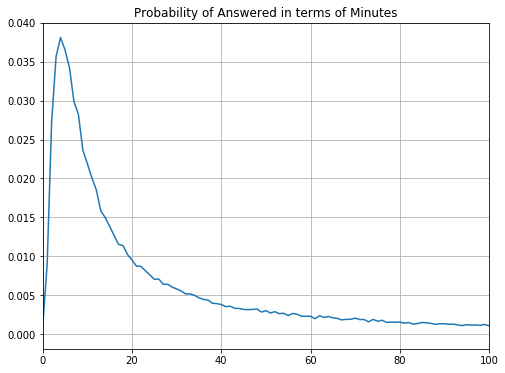

In [237]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,100)
plt.grid()
plt.title('Probability of Answered in terms of Minutes')

## Cumulative Probability 

In [238]:
fre_mins.head()

,Frequency,mins,Probabiity
115,220,0.0,0.000932
19,2118,1.0,0.008970
6,6429,2.0,0.027228
2,8427,3.0,0.035690
0,9002,4.0,0.038125


In [239]:
fre_mins['cum_pro'] = np.cumsum(list(fre_mins.Probabiity))

In [240]:
fre_mins.head()

,Frequency,mins,Probabiity,cum_pro
115,220,0.0,0.000932,0.000932
19,2118,1.0,0.008970,0.009902
6,6429,2.0,0.027228,0.037130
2,8427,3.0,0.035690,0.072820
0,9002,4.0,0.038125,0.110945


Text(0.5,0,'cumulative probability')

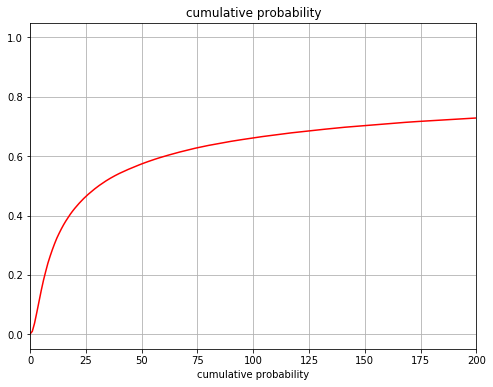

In [241]:
fig=plt.figure(figsize=(8,6))
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,200)
plt.grid()
plt.title('cumulative probability')
plt.xlabel('cumulative probability')

## Summary of Probability Plots

Text(0.5,1,'cumulative probability')

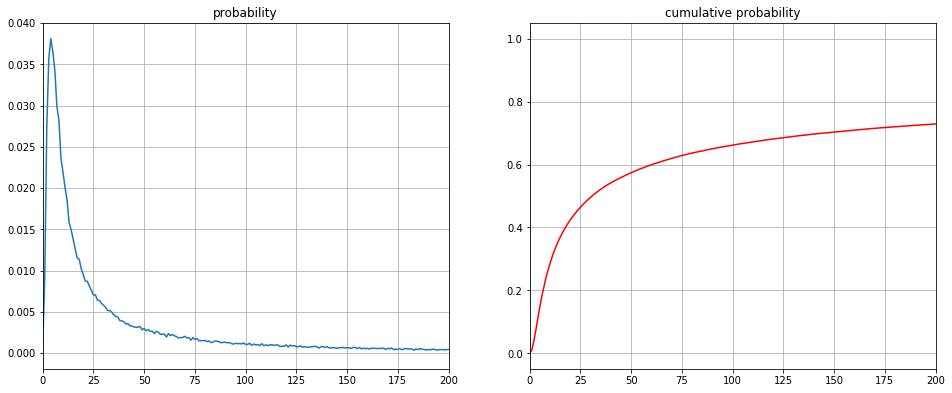

In [242]:
fig=plt.figure(figsize=(16,14))
plt.subplot(221)
plt.plot(fre_mins.mins, fre_mins.Probabiity)
plt.xlim(0,200)
plt.grid()
plt.title('probability')
plt.subplot(222)
plt.plot(fre_mins.mins, fre_mins.cum_pro, color='red')
plt.xlim(0,200)
plt.grid()
plt.title('cumulative probability')